# Checkpoint 1 point 1

In [1]:
from functions_cp1 import *
import sys
main_folder = "./"
spe10_folder = main_folder + "spe10"
sys.path.insert(1, spe10_folder)
from spe10 import Spe10
from pathos.multiprocessing import _ProcessPool as Pool


/home/dave/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore


In [2]:
def upscale(sd, perm, dir, export_folder=None):
    """
    Compute the averaged gradient and flux for a given subdomain and direction of the pressure
    gradient.

    Args:
        sd (pp.Grid): The grid representing the subdomain.
        perm (dict): The permeability of the subdomain divided in the fields "kxx" and "kyy"
        dir (int): The direction of the flow, 0 means x-direction and 1 means y-direction.
        export_folder (str): If given, path where to export the results.
            Default to None, no exporting.

    Returns:
        (np.ndarray, np.ndarray): averaged gradient and flux.
    """
    perm_tensor = pp.SecondOrderTensor(kxx=perm["kxx"], kyy=perm["kyy"])
    
    #pp.plot_grid(sd, perm_tensor, plot_2d=True)

    # Boundary conditions
    b_faces = sd.tags["domain_boundary_faces"].nonzero()[0]
    
    b_face_centers = sd.face_centers[:, b_faces]

    # Find the min and max values of the boundary faces
    sd_min = np.amin(sd.face_centers[dir, :])
    sd_max = np.amax(sd.face_centers[dir, :])

    # define outflow and inflow type boundary conditions
    out_flow = np.isclose(b_face_centers[dir, :], sd_max)
    in_flow = np.isclose(b_face_centers[dir, :], sd_min)

    # define the labels and values for the boundary faces
    labels = np.array(["neu"] * b_faces.size)
    labels[np.logical_or(in_flow, out_flow)] = "dir"
    
    bc_val = np.zeros(sd.num_faces)
    bc_val[b_faces[in_flow]] = sd_max - sd_min
    bc = pp.BoundaryCondition(sd, b_faces, labels)

    # Collect all parameters in a dictionary
    key = "flow"
    parameters = {"second_order_tensor": perm_tensor, "bc": bc, "bc_values": bc_val}
    data = pp.initialize_default_data(sd, {}, key, parameters)
    
    # Discretize the problem (construct the lhr and rhs)
    pfa = pp.Mpfa(key)
    pfa.discretize(sd, data)
    A_pfa, b_pfa = pfa.assemble_matrix_rhs(sd, data)
    p = sps.linalg.spsolve(A_pfa, b_pfa)


    # Export the solution
    if export_folder is not None:
        save = pp.Exporter(sd, "sol", folder_name=export_folder)
        save.write_vtu([("p", p), ("log_perm", np.log10(perm["kxx"]))])

    # Post-process the solution to get the flux
    # print("beginning gradient computation")
    return compute_avg_q_grad(sd, p, data, key, bc, bc_val)
    

In [3]:
    
def compute_tensor(grad_h, grad_v, q_h, q_v):
    """
    Compute the upscaled permeability tensor.

    Args:
        grad_h (np.ndarray): Gradient in the horizontal direction.
        grad_v (np.ndarray): Gradient in the vertical direction.
        q_h (np.ndarray): Flux in the horizontal direction.
        q_v (np.ndarray): Flux in the vertical direction.

    Returns:
        perm (np.ndarray): Upscaled permeability tensor.

    The function solves a linear system to obtain the upscaled permeability tensor
    based on the given gradients and fluxes. It enforces numerical symmetry and
    checks if the resulting tensor is symmetric positive definite (SPD).
    """
    
    ## Assembling spd matrix for least squares
    A = np.array([[grad_h[0], grad_h[1], 0, 0],
                  [0, 0, grad_h[0], grad_h[1]],
                  [grad_v[0], grad_v[1], 0, 0],
                  [0, 0, grad_v[0], grad_v[1]],
                  [0, 1, -1,0]])
    b = np.array([q_h[0], q_h[1], q_v[0], q_v[1],0])
    
    # Solve the linear system
    K_avg = np.linalg.lstsq(A, b,rcond = None)[0]

    perm = nearest_spd(K_avg.reshape(2, 2)).ravel()
    
    return perm
    
def to_parallel(sub_sd_id, sub_sd, perm_dict, part, folder_results):
    mask = part == sub_sd_id
    sub_perm = {key: val[mask] for key, val in perm_dict.items()}
    q_h, grad_h = upscale(sub_sd, sub_perm, 0, folder_results)
    q_v, grad_v = upscale(sub_sd, sub_perm, 1, folder_results)
    kk = compute_tensor(grad_h, grad_v, q_h, q_v)
    return [kk[0], kk[1], kk[2], kk[3]], mask


In [4]:
def Checkpoint1_solution(selected_layers, folder_results):

    # Read the SPE10 grid
    spe10 = Spe10(selected_layers)

    perm_folder = spe10_folder + "/perm/"
    spe10.read_perm(perm_folder)
    perm_dict = spe10.perm_as_dict()

    num_part = 20
    part, sub_sds, sd_coarse = coarse_grid(spe10.sd, num_part)

    # Define the upscaled permeability
    kxx_up = np.zeros(spe10.sd.num_cells)
    kxy_up = np.zeros(spe10.sd.num_cells)
    kyx_up = np.zeros(spe10.sd.num_cells)
    kyy_up = np.zeros(spe10.sd.num_cells)

    result = []
    args = [(sub_sd_id, sub_sd, perm_dict, part, folder_results) for sub_sd_id, sub_sd in enumerate(sub_sds)]
    with Pool() as pool:
        for local_perm, mask in pool.starmap(to_parallel, args, chunksize = 2):
            kxx_up[mask], kxy_up[mask], kyx_up[mask], kyy_up[mask] = local_perm
            result.append(local_perm)

    # Submit tasks to ray
    # results_ids = [to_parallel_ray.remote(*arg) for arg in args]
    #result = ray.get([to_parallel_ray.remote(*arg) for arg in args])


    # for result_id in results_ids:
    #     local_result, mask = ray.get(result_id)
    #     kxx_up[mask], kxy_up[mask], kyx_up[mask], kyy_up[mask] = local_result
    #     #print(local_result)
    #     result.append(local_result)
        return sd_coarse, result

In [5]:
selected_layers = 10
folder_results = main_folder + "results_present/"
sd_coarse, result = Checkpoint1_solution(selected_layers, folder_results)

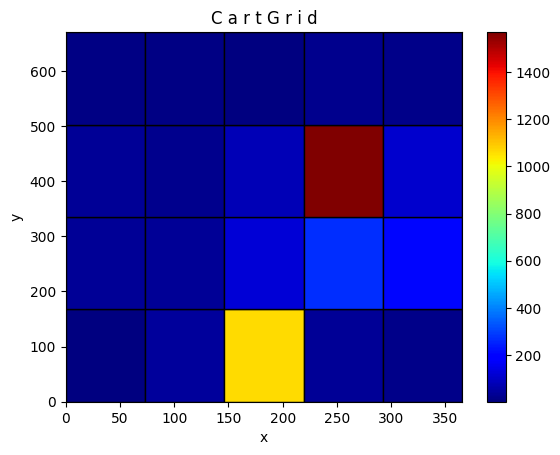

In [6]:
# visualization of results

kxx = np.zeros([20])
i = 0
for elem in result:
    kxx[i] = elem[0]
    i = i + 1

pp.plot_grid(sd_coarse, kxx, plot_2d=True)

# Export the solution
if folder_results is not None:
    save = pp.Exporter(sd_coarse, "sol_coarse", folder_name=folder_results)
    save.write_vtu([("log_perm", np.log10(kxx))])